In [2]:
import torch 
import math
import numpy as np
import pandas as pd
import skimage 
import src
import src.datasets
import os
import scipy
import sklearn
import seaborn as sns

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import balanced_accuracy_score

from src.evaluation import load_iccns
from src.utils import set_random_seeds
from hydra import initialize, compose
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from torch.nn import functional as F
from skimage.segmentation import mark_boundaries
from lime import lime_image
from sklearn import svm, tree
from aif360.sklearn.metrics import equal_opportunity_difference
from sklearn.neural_network import MLPClassifier

/opt/anaconda3/envs/ot-bias/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

In [4]:
set_random_seeds(65)

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## Experiment 1

In [5]:
def extract_attribute(file, attributes):
    for attr in attributes:
        if attr in file:
            return attr

In [6]:
# paths 
attributes = ["Wearing_Necktie", "Eyeglasses", "Wearing_Hat", "Smiling"]

celebA_csv = "../data/celeba/list_attr_celeba.csv"
uniform_csv = "../data/celeba/experiment1_uniform_sample.csv"
biased_csvs = dict()
dataframes = dict()
for attr in attributes:
    biased_csvs[attr] = ["../data/celeba/experiment1_biased_sample_{}_{}.csv".format(attr, n) for n in [10,30,60,90]]
    dataframes[attr] = [pd.read_csv(biased_csvs[attr][i]) for i in range(4)]


In [7]:
df = pd.read_csv(uniform_csv)

for attr in attributes:
    print(attr, len(df[df[attr]==1])/len(df))

Wearing_Necktie 0.072
Eyeglasses 0.06744444444444445
Wearing_Hat 0.04477777777777778
Smiling 0.47355555555555556


In [8]:
unif_df = pd.read_csv(uniform_csv)

In [9]:
wasserstein_df = pd.read_csv("../results/experiment1_wasserstein.tsv", sep= "\t", header=None)
wasserstein_df.columns = ["X", "Y", "wasserstein"]

wasserstein_df["attr"] = wasserstein_df["X"].apply(lambda x: extract_attribute(x, attributes))

wasserstein = {attr: list(reversed(list(wasserstein_df[wasserstein_df["attr"] == attr].wasserstein)))\
               for attr in attributes}

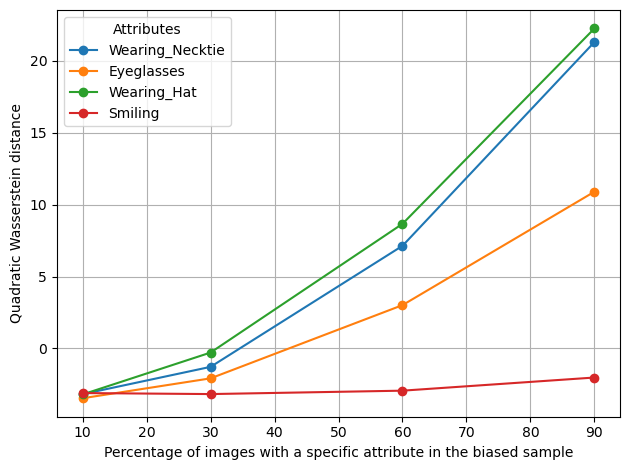

In [9]:
for i, item in enumerate(wasserstein.items()):

    attr, scores = item
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic Wasserstein distance")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Wasserstein_distance_plot.png")
plt.show()

In [10]:
distances = dict()
decision_functions = dict()
accuracy = dict()

space_unif = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
         for file in unif_df["image_id"]]

for attr in attributes:
    distances[attr] = dict()
    decision_functions[attr] = dict()
    accuracy[attr] = dict()
    
    for j in range(4):
        n = [10,30,60,90][j]
        
        dataframes[attr][j]["biased"] = 1
        unif_df["biased"] = -1
        
        space = [torch.load("../data/celeba/resnet18/" + file[:-4] + ".pt").detach().numpy()\
                 for file in dataframes[attr][j]["image_id"]] + space_unif
        
        concat = pd.concat([dataframes[attr][j], unif_df])
        y = concat["biased"]

        X = np.concatenate(space)
        y = np.array(y)
        
        classifier = svm.LinearSVC(C=.01)
        
        classifier.fit(X, y)
        distances[attr][n] = (.5*(classifier.decision_function(X)/np.linalg.norm(classifier.coef_))**2).mean()
        accuracy[attr][n] = classifier.score(X, y)
        
        df = concat[concat["biased"] == 1]
        df["distance"] = classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_)
        decision_functions[attr][n] = df

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/1695171430.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_)
/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/1695171430.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance"] = classifier.decision_function(X[y == 1])/np.linalg.norm(classifier.coef_)
/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/1695171430.p

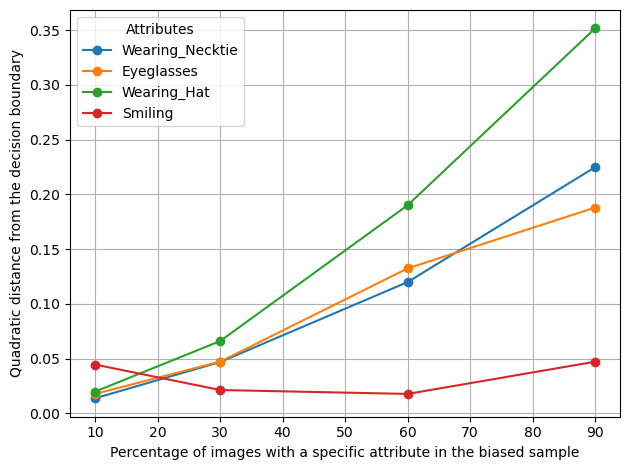

In [14]:
for  i, item in enumerate(distances.items()):
    
    attr, score_dict = item

    scores = [s for n, s in score_dict.items()]
    c = ["tab:blue", "tab:orange", "tab:green", "tab:red"][i]
    plt.plot([10,30,60,90], scores, "-o", c=c)

plt.title("")
plt.xlabel("Percentage of images with a specific attribute in the biased sample")
plt.ylabel("Quadratic distance from the decision boundary")
plt.legend(wasserstein.keys(), title="Attributes")
plt.grid()

plt.tight_layout()
plt.savefig("../results/Experiment1/Distances_plot.png")
plt.show()

In [12]:
df = pd.DataFrame(columns = ["attribute", "method", "spearman_correlation", "p-value"])
for  i, item in enumerate(accuracy.items()):
    attr = item[0]
    acc = [accuracy for key, accuracy in item[1].items()]
    was = wasserstein[attr]

    corr_was = scipy.stats.spearmanr(was, [10,30,60,90])
    corr_acc = scipy.stats.spearmanr(acc, [10,30,60,90])
    
    df.loc[len(df)] = [attr, "Wasserstein", corr_was[0], corr_was[1] ]
    df.loc[len(df)] = [attr, "SVM", corr_acc[0], corr_acc[1]]

df

,attribute,method,spearman_correlation,p-value
0,Wearing_Necktie,Wasserstein,1.0,0.0
1,Wearing_Necktie,SVM,1.0,0.0
2,Eyeglasses,Wasserstein,1.0,0.0
3,Eyeglasses,SVM,1.0,0.0
4,Wearing_Hat,Wasserstein,1.0,0.0
5,Wearing_Hat,SVM,1.0,0.0
6,Smiling,Wasserstein,0.8,0.2
7,Smiling,SVM,0.2,0.8


In [13]:
print(df.set_index(["attribute"]).to_latex())

\begin{tabular}{llrr}
\toprule
{} &       method &  spearman\_correlation &  p-value \\
attribute       &              &                       &          \\
\midrule
Wearing\_Necktie &  Wasserstein &                   1.0 &      0.0 \\
Wearing\_Necktie &          SVM &                   1.0 &      0.0 \\
Eyeglasses      &  Wasserstein &                   1.0 &      0.0 \\
Eyeglasses      &          SVM &                   1.0 &      0.0 \\
Wearing\_Hat     &  Wasserstein &                   1.0 &      0.0 \\
Wearing\_Hat     &          SVM &                   1.0 &      0.0 \\
Smiling         &  Wasserstein &                   0.8 &      0.2 \\
Smiling         &          SVM &                   0.2 &      0.8 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/1648947662.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.set_index(["attribute"]).to_latex())


## Experiment 2

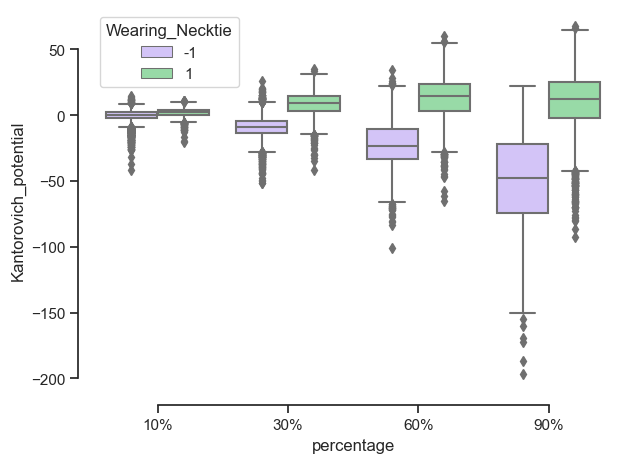

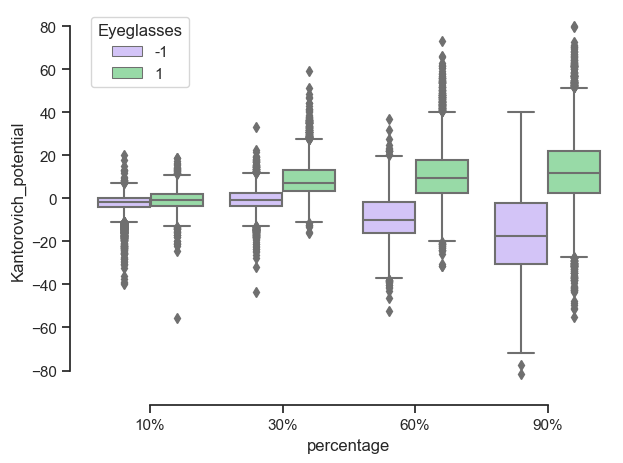

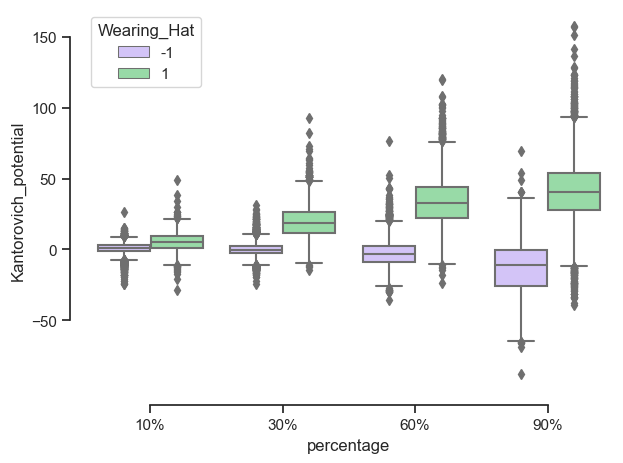

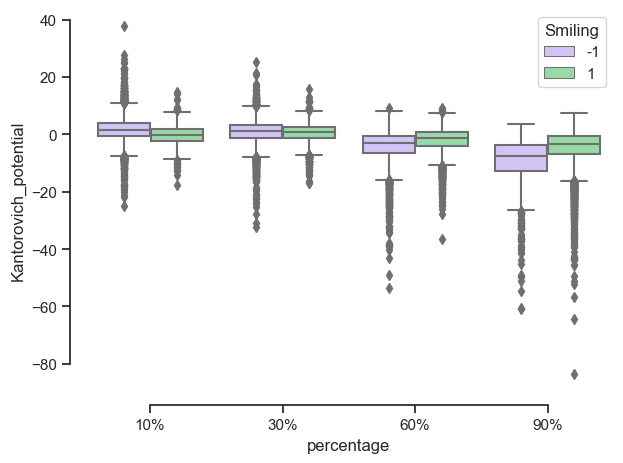

In [16]:
sns.set_theme(style="ticks", palette="pastel")

for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        dataframes[attr][i]["percentage"] = "{}%".format(n)

    data = pd.concat(dataframes[attr])

    sns.boxplot(data=data,
                x="percentage",
                y="distance",
                hue=attr,
                palette=["m", "g"])
    
    sns.despine(offset=10, trim=True)
    
    plt.tight_layout()
    
    plt.savefig("../results/Experiment1/{0}_Boxplot.png".format(attr, n))
    
    plt.show()

In [16]:
attributes_list = list()
perc = [10,30,60,90] * 4
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        df = dataframes[attr][i]
        col1 = df[df[attr] == 1].Kantorovich_potential
        col2 = df[df[attr] == -1].Kantorovich_potential
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [17]:
print(table.set_index(["attribute", "percentage"]).to_latex())

\begin{tabular}{llrr}
\toprule
        &    &  statistic &        pvalue \\
attribute & percentage &            &               \\
\midrule
Wearing\_Necktie & 10 &   0.001358 &  9.960244e-01 \\
        & 30 &   0.000000 &  1.000000e+00 \\
        & 60 &   0.000000 &  1.000000e+00 \\
        & 90 &   0.000000 &  1.000000e+00 \\
Eyeglasses & 10 &   0.010123 &  8.407604e-01 \\
        & 30 &   0.000000 &  1.000000e+00 \\
        & 60 &   0.000000 &  1.000000e+00 \\
        & 90 &   0.000000 &  1.000000e+00 \\
Wearing\_Hat & 10 &   0.009259 &  8.644351e-01 \\
        & 30 &   0.000000 &  1.000000e+00 \\
        & 60 &   0.000000 &  1.000000e+00 \\
        & 90 &   0.000000 &  1.000000e+00 \\
Smiling & 10 &   0.221235 &  3.119805e-35 \\
        & 30 &   0.079894 &  3.099225e-11 \\
        & 60 &   0.000093 &  9.998766e-01 \\
        & 90 &   0.000247 &  9.997202e-01 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/2333445097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.set_index(["attribute", "percentage"]).to_latex())


In [18]:
decision_functions["Wearing_Hat"][30]

,Unnamed: 0,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,Kantorovich_potential,biased,distance
0,56340,056341.jpg,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,-1,1,1,27.953033,1,0.843802
1,119516,119517.jpg,-1,-1,-1,1,-1,-1,1,1,...,-1,-1,1,-1,-1,-1,1,0.585236,1,0.378755
2,179591,179592.jpg,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,1,24.885651,1,0.396486
3,193156,193157.jpg,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,2.343109,1,0.419778
4,109775,109776.jpg,1,-1,-1,1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,1,10.573990,1,0.113586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,128630,128631.jpg,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,-1,-2.987167,1,-0.442962
8996,117080,117081.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,-1,2.862946,1,-0.000305
8997,85258,085259.jpg,1,-1,1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,1,1,-3.154587,1,-0.308100
8998,63145,063146.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-4.246490,1,0.082511


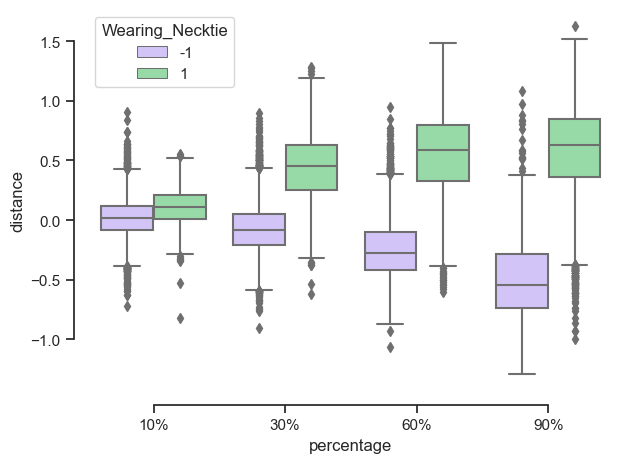

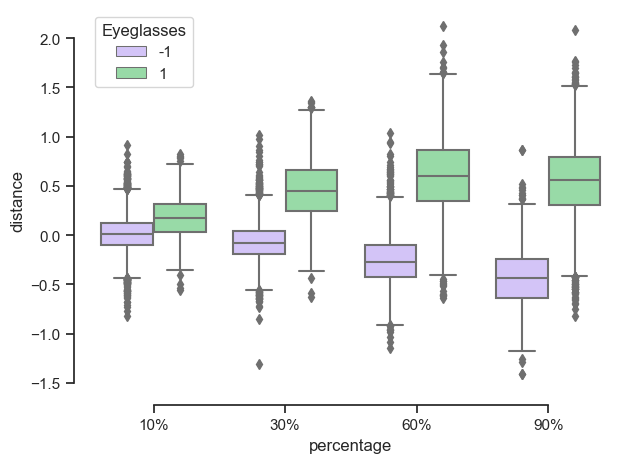

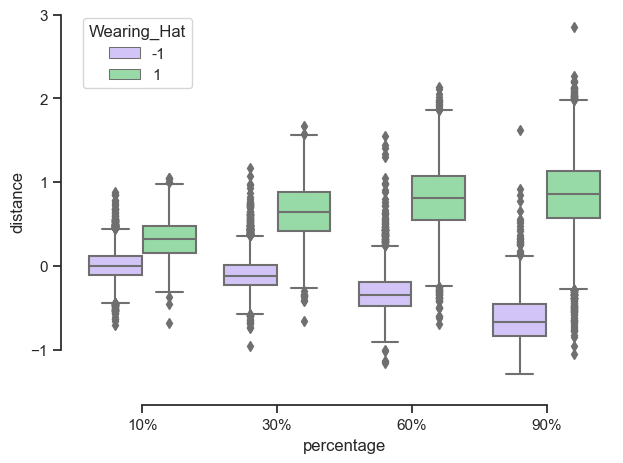

/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/1050380628.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_functions[attr][n]["percentage"] = "{}%".format(n)


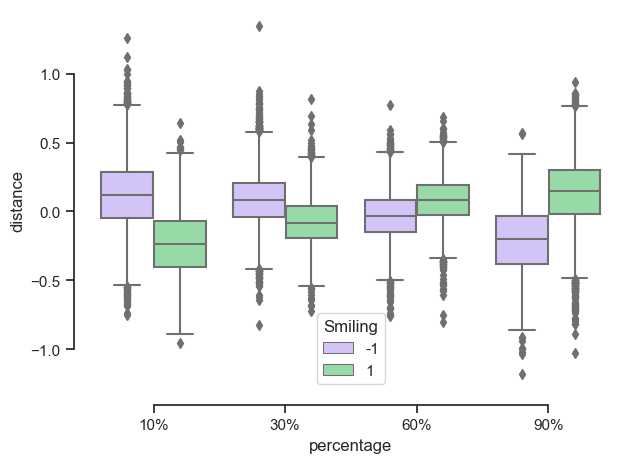

In [19]:
for attr in attributes:
    for i in range(4):
        n = [10, 30, 60, 90][i]
        decision_functions[attr][n]["percentage"] = "{}%".format(n)

    data = pd.concat([d for n,d in decision_functions[attr].items()])

    sns.boxplot(data=data,
                x="percentage",
                y="distance",
                hue=attr,
                palette=["m", "g"])
    
    sns.despine(offset=10, trim=True)
    
    plt.tight_layout()
    
    plt.savefig("../results/Experiment1/{0}_distance_Boxplot.png".format(attr, n))
    
    plt.show()

In [20]:
attributes_list = list()
perc = [10,30,60,90] * 4
stats = list()
p_val= list()

for attr in attributes:
    for i in range(4):
        n = [10,30,60,90][i]
        df = decision_functions[attr][n]
        col1 = df[df[attr] == 1].distance
        col2 = df[df[attr] == -1].distance
        
        test = ks_2samp(col1, col2, alternative = "greater")

        attributes_list.append(attr)
        stats.append(test.statistic)
        p_val.append(test.pvalue)

table = pd.DataFrame({"attribute" : attributes_list, "percentage" : perc, "statistic" : stats, "pvalue" : p_val})

In [21]:
print(table.set_index(["attribute", "percentage"]).to_latex())

\begin{tabular}{llrr}
\toprule
        &    &  statistic &         pvalue \\
attribute & percentage &            &                \\
\midrule
Wearing\_Necktie & 10 &   0.002469 &   9.883808e-01 \\
        & 30 &   0.000000 &   1.000000e+00 \\
        & 60 &   0.000000 &   1.000000e+00 \\
        & 90 &   0.000000 &   1.000000e+00 \\
Eyeglasses & 10 &   0.000247 &   9.997202e-01 \\
        & 30 &   0.000000 &   1.000000e+00 \\
        & 60 &   0.000000 &   1.000000e+00 \\
        & 90 &   0.000000 &   1.000000e+00 \\
Wearing\_Hat & 10 &   0.000988 &   9.976981e-01 \\
        & 30 &   0.000000 &   1.000000e+00 \\
        & 60 &   0.000000 &   1.000000e+00 \\
        & 90 &   0.000000 &   1.000000e+00 \\
Smiling & 10 &   0.548148 &  2.692604e-212 \\
        & 30 &   0.356032 &  5.954813e-209 \\
        & 60 &   0.000278 &   9.994076e-01 \\
        & 90 &   0.000000 &   1.000000e+00 \\
\bottomrule
\end{tabular}



/var/folders/8p/14dt3sw51h52d_5d395588zh0000gn/T/ipykernel_4112/2333445097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.set_index(["attribute", "percentage"]).to_latex())
